In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
from SuchTree import SuchTree, SuchLinkedTrees
import graphkernels.kernels as gk
import igraph
import pandas
import seaborn
import json
import pyprind

In [3]:
studies = json.load( open( '../SuchTree/data/studies.json' ) )

In [4]:
def load_study( study ) :
    T1  = SuchTree( '../SuchTree/' + study['host'] )
    T2  = SuchTree( '../SuchTree/' + study['guest'] )
    links = pandas.DataFrame.from_csv( '../SuchTree/' + study['links'] )
    links = links.loc[ T1.leafs.keys() ]
    links = links[ T2.leafs.keys() ]
    return SuchLinkedTrees( T1, T2, links )

def SLT_to_igraph( SLT ) :
    g = igraph.Graph.Weighted_Adjacency( SLT.adjacency().tolist(),
                                         mode=igraph.ADJ_UNDIRECTED )
    
    subset_b_length = len( list( SLT.TreeB.get_descendant_nodes( SLT.subset_b_root ) ) )
    
    g.vs['color'] = ['#e1e329ff'] * SLT.TreeA.length + ['#24878dff'] * subset_b_length
    g.vs['label'] = [ 'h' + str(i) for i in range(SLT.TreeA.length) ] +\
                    [ 'g' + str(i) for i in range(subset_b_length) ]
    g.vs['tree'] = [ 0 ]  * SLT.TreeA.length + [ 1 ] * subset_b_length
    return g

p = pyprind.ProgBar( len(studies) )

for n, study in enumerate(studies) :
    SLT = load_study( study )
    study['SLT'] = SLT
    study['igraph'] = SLT_to_igraph( SLT )
    p.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


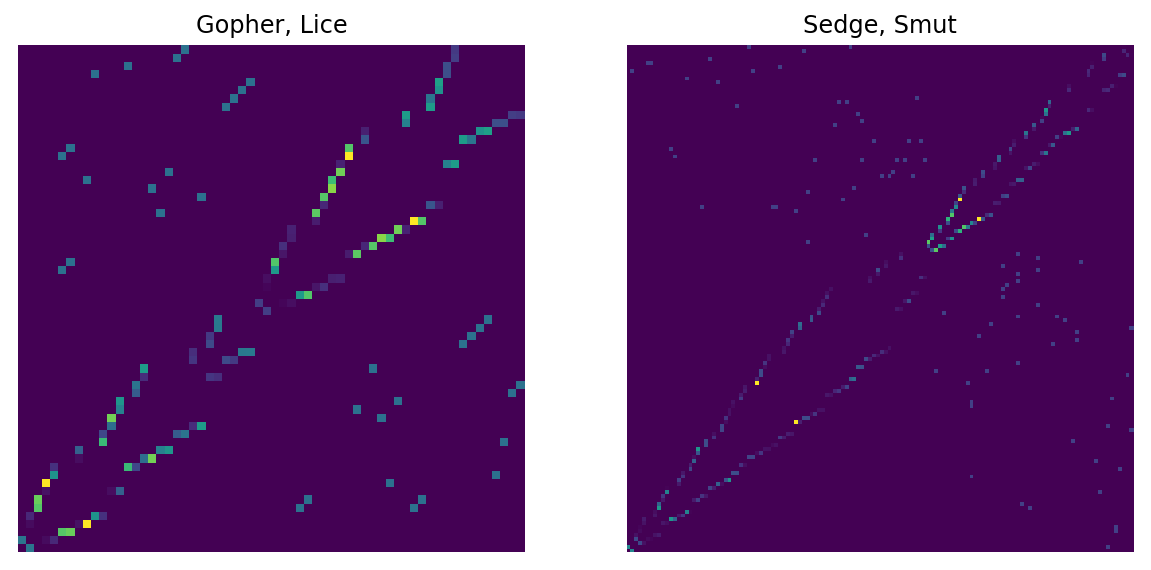

In [5]:
figure( figsize=(10,10) )

subplot(1,2,1)
title( studies[0]['name'] )
seaborn.heatmap( studies[0]['SLT'].adjacency(), cmap='viridis', 
                 vmin=0, vmax=1,
                 xticklabels=False, yticklabels=False,
                 cbar=False, square=True ).invert_yaxis()
subplot(1,2,2)
title( studies[1]['name'] )
seaborn.heatmap( studies[1]['SLT'].adjacency(), cmap='viridis', 
                 vmin=0, vmax=1,
                 xticklabels=False, yticklabels=False,
                 cbar=False, square=True ).invert_yaxis()

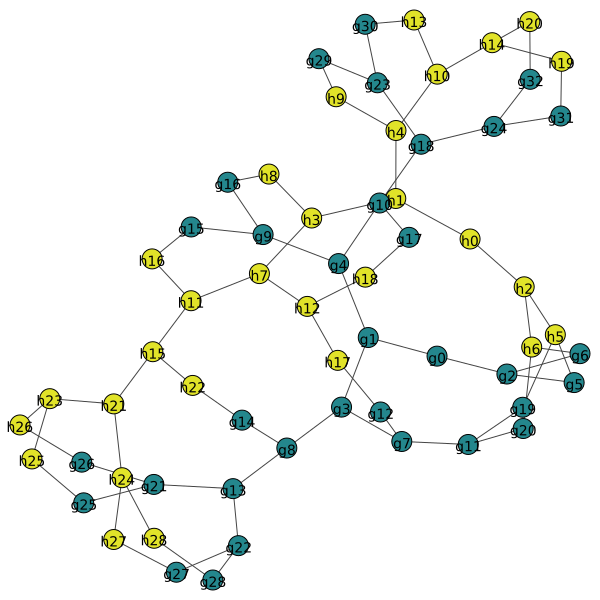

In [6]:
layout = studies[0]['igraph'].layout_kamada_kawai()
#layout = studies[0]['igraph'].layout_grid()
#g.layout_grid()

igraph.plot( studies[0]['igraph'], layout=layout )

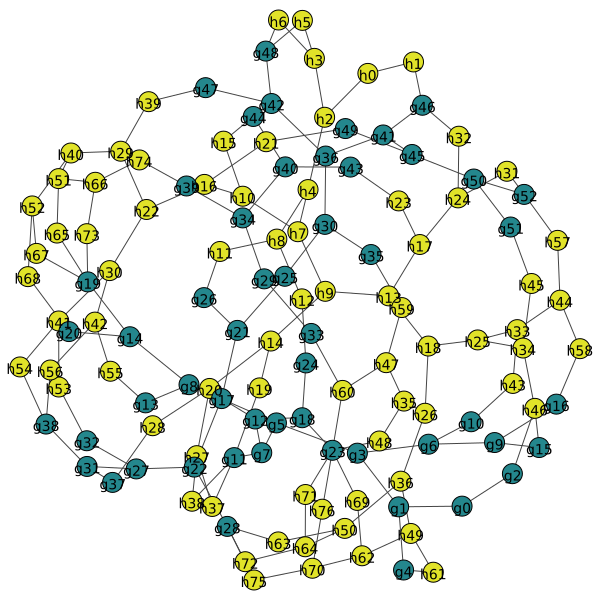

In [7]:
layout = studies[1]['igraph'].layout_kamada_kawai()

igraph.plot( studies[1]['igraph'], layout=layout )

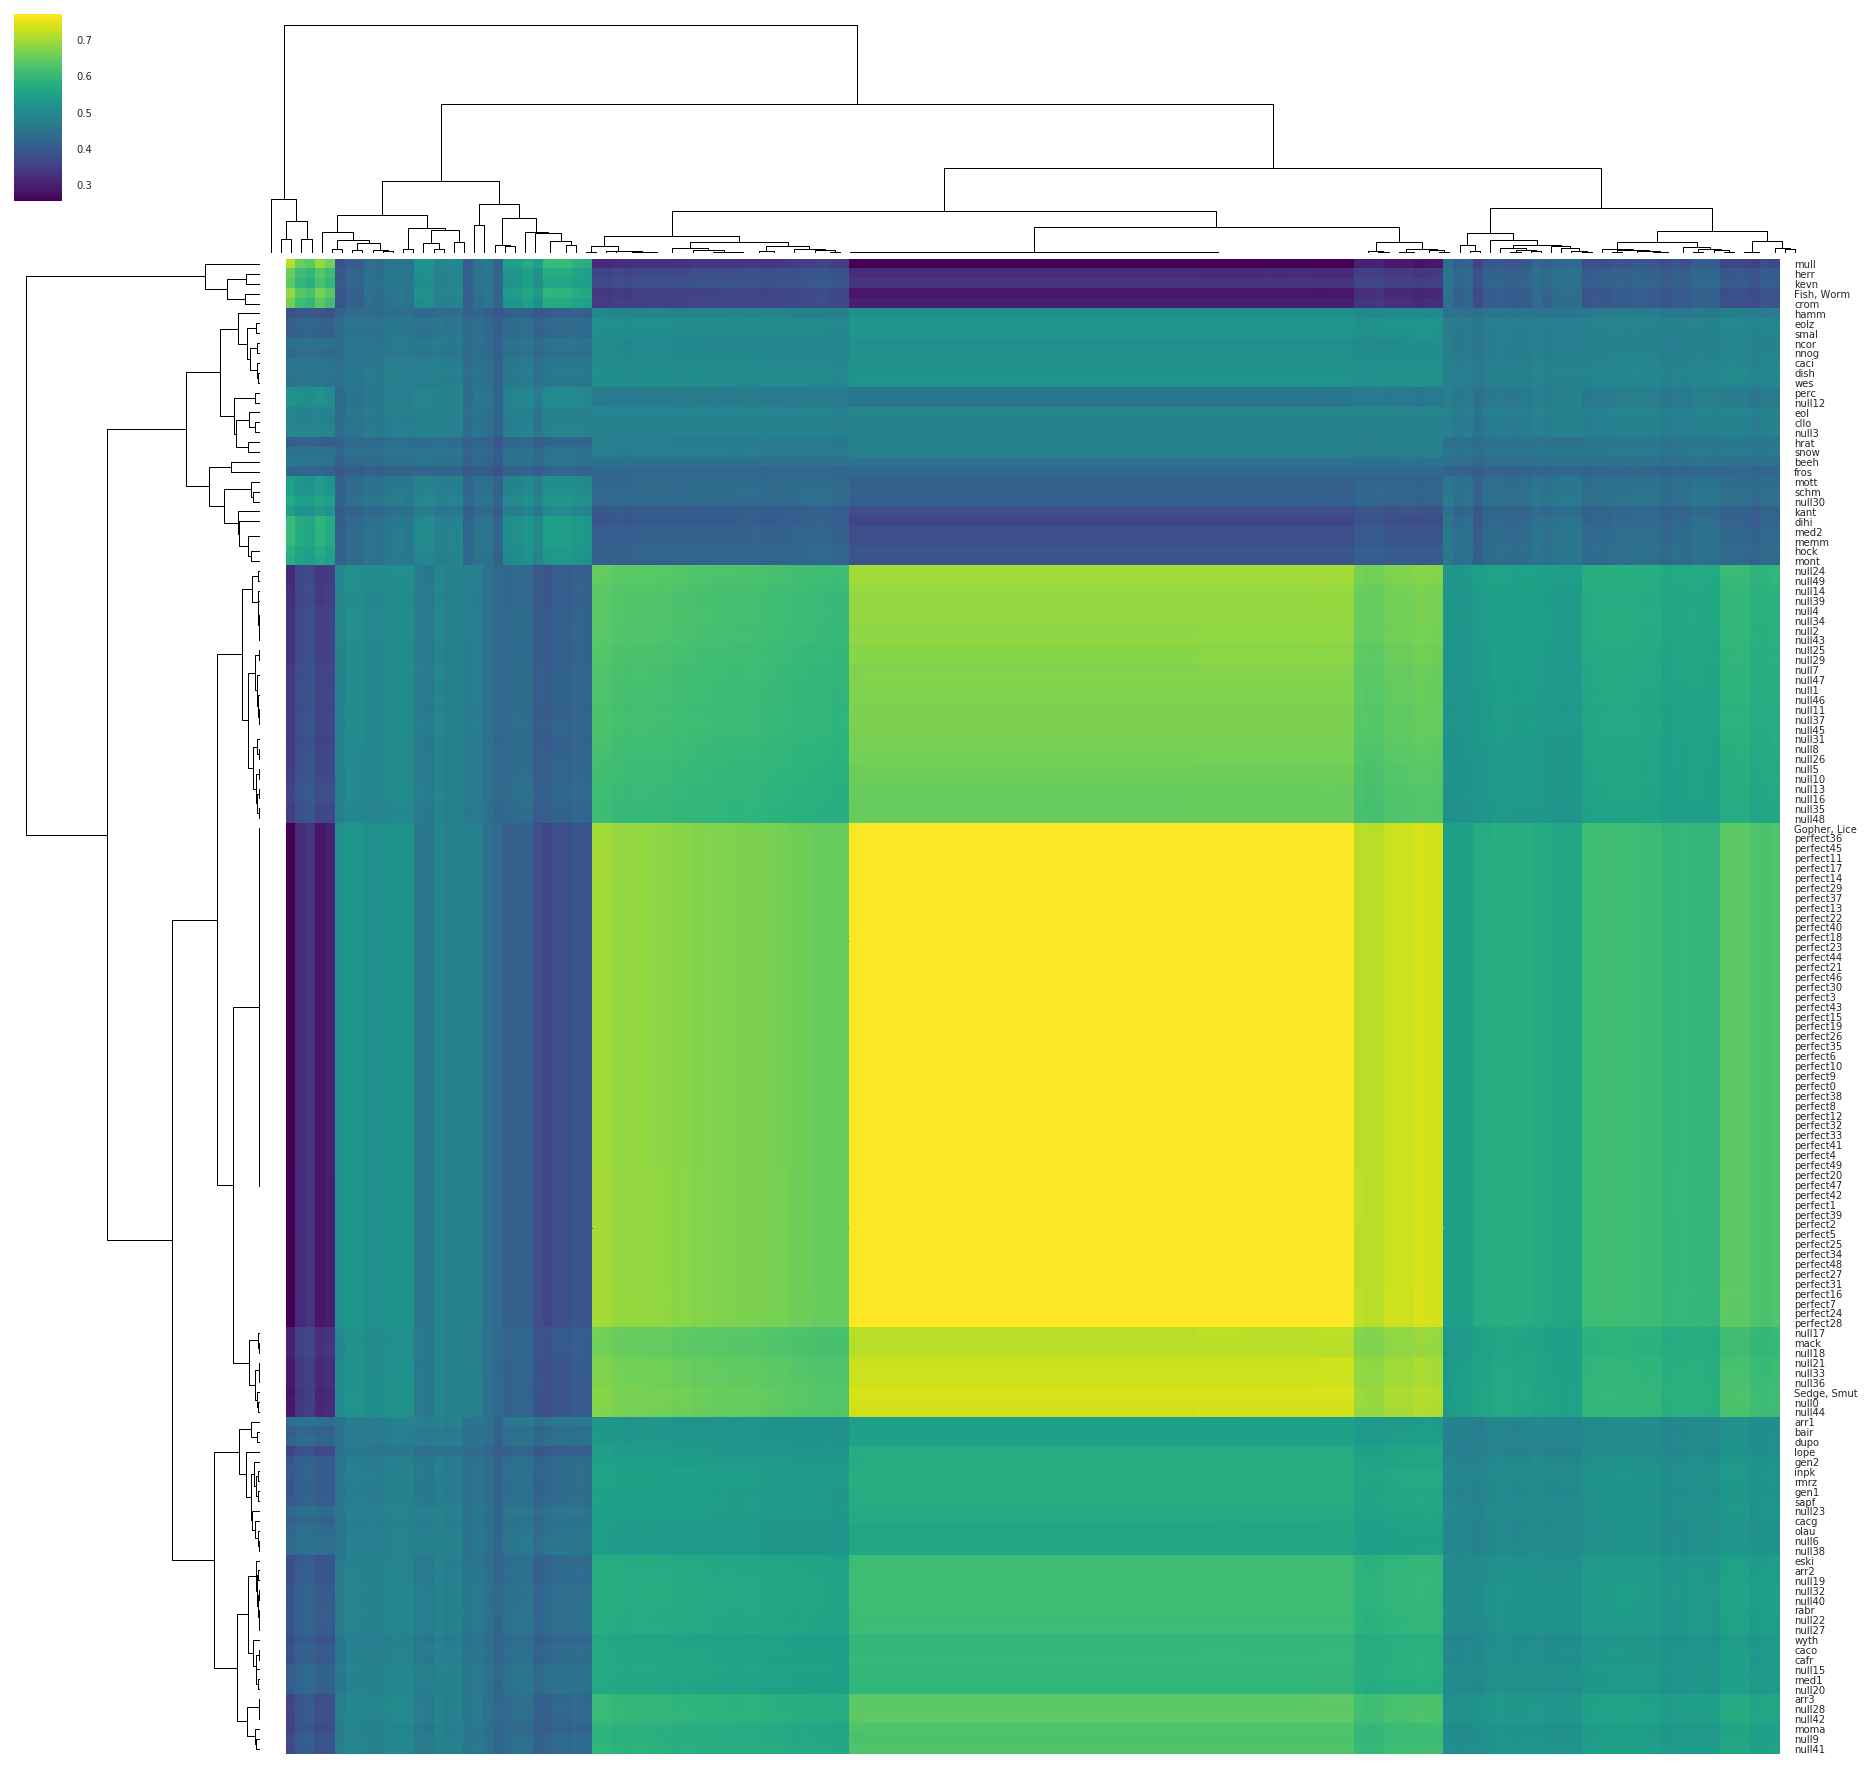

In [8]:
K = gk.CalculateConnectedGraphletKernel( [ i['igraph'] for i in studies ] )

seaborn.set( font_scale=0.5 )
seaborn.clustermap( K, method='weighted', metric='braycurtis',
                    cmap='viridis', figsize=(16,16),
                    xticklabels=False, yticklabels=[ i['name'] for i in studies ],
                    cbar=True, square=True )

In [9]:
from os import listdir

prefix = '../ManyTrees/set2/'

p = pyprind.ProgBar( len(listdir(prefix)) )

data = []
moments = []
SLTs = {}
igraphs = {}
for run in listdir( prefix ) :
    p.update()
    if run == 'run.log' : continue
    data.append( pandas.read_csv( prefix + run + '/data.csv' ) )
    moments.append( pandas.read_csv( prefix + run + '/moments.csv' ) )
    
    T1 = SuchTree( prefix + run + '/host.relaxed.tree' )
    T2 = SuchTree( prefix + run + '/guest.relaxed.tree' )
    LK = pandas.read_csv( prefix + run + '/links.csv', index_col=0 )
    SLT = SuchLinkedTrees( T1, T2, LK )
    SLTs[ run ] = SLT
    
    igraphs[ run ] = SLT_to_igraph( SLT )
    
data = pandas.concat( data, ignore_index=True )
moments = pandas.concat( moments, ignore_index=True )
data = data.join(moments)
data.index = [ i.split('/')[1] for i in data['prefix'] ]
data.drop( 'prefix', axis=1, inplace=True )


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:07


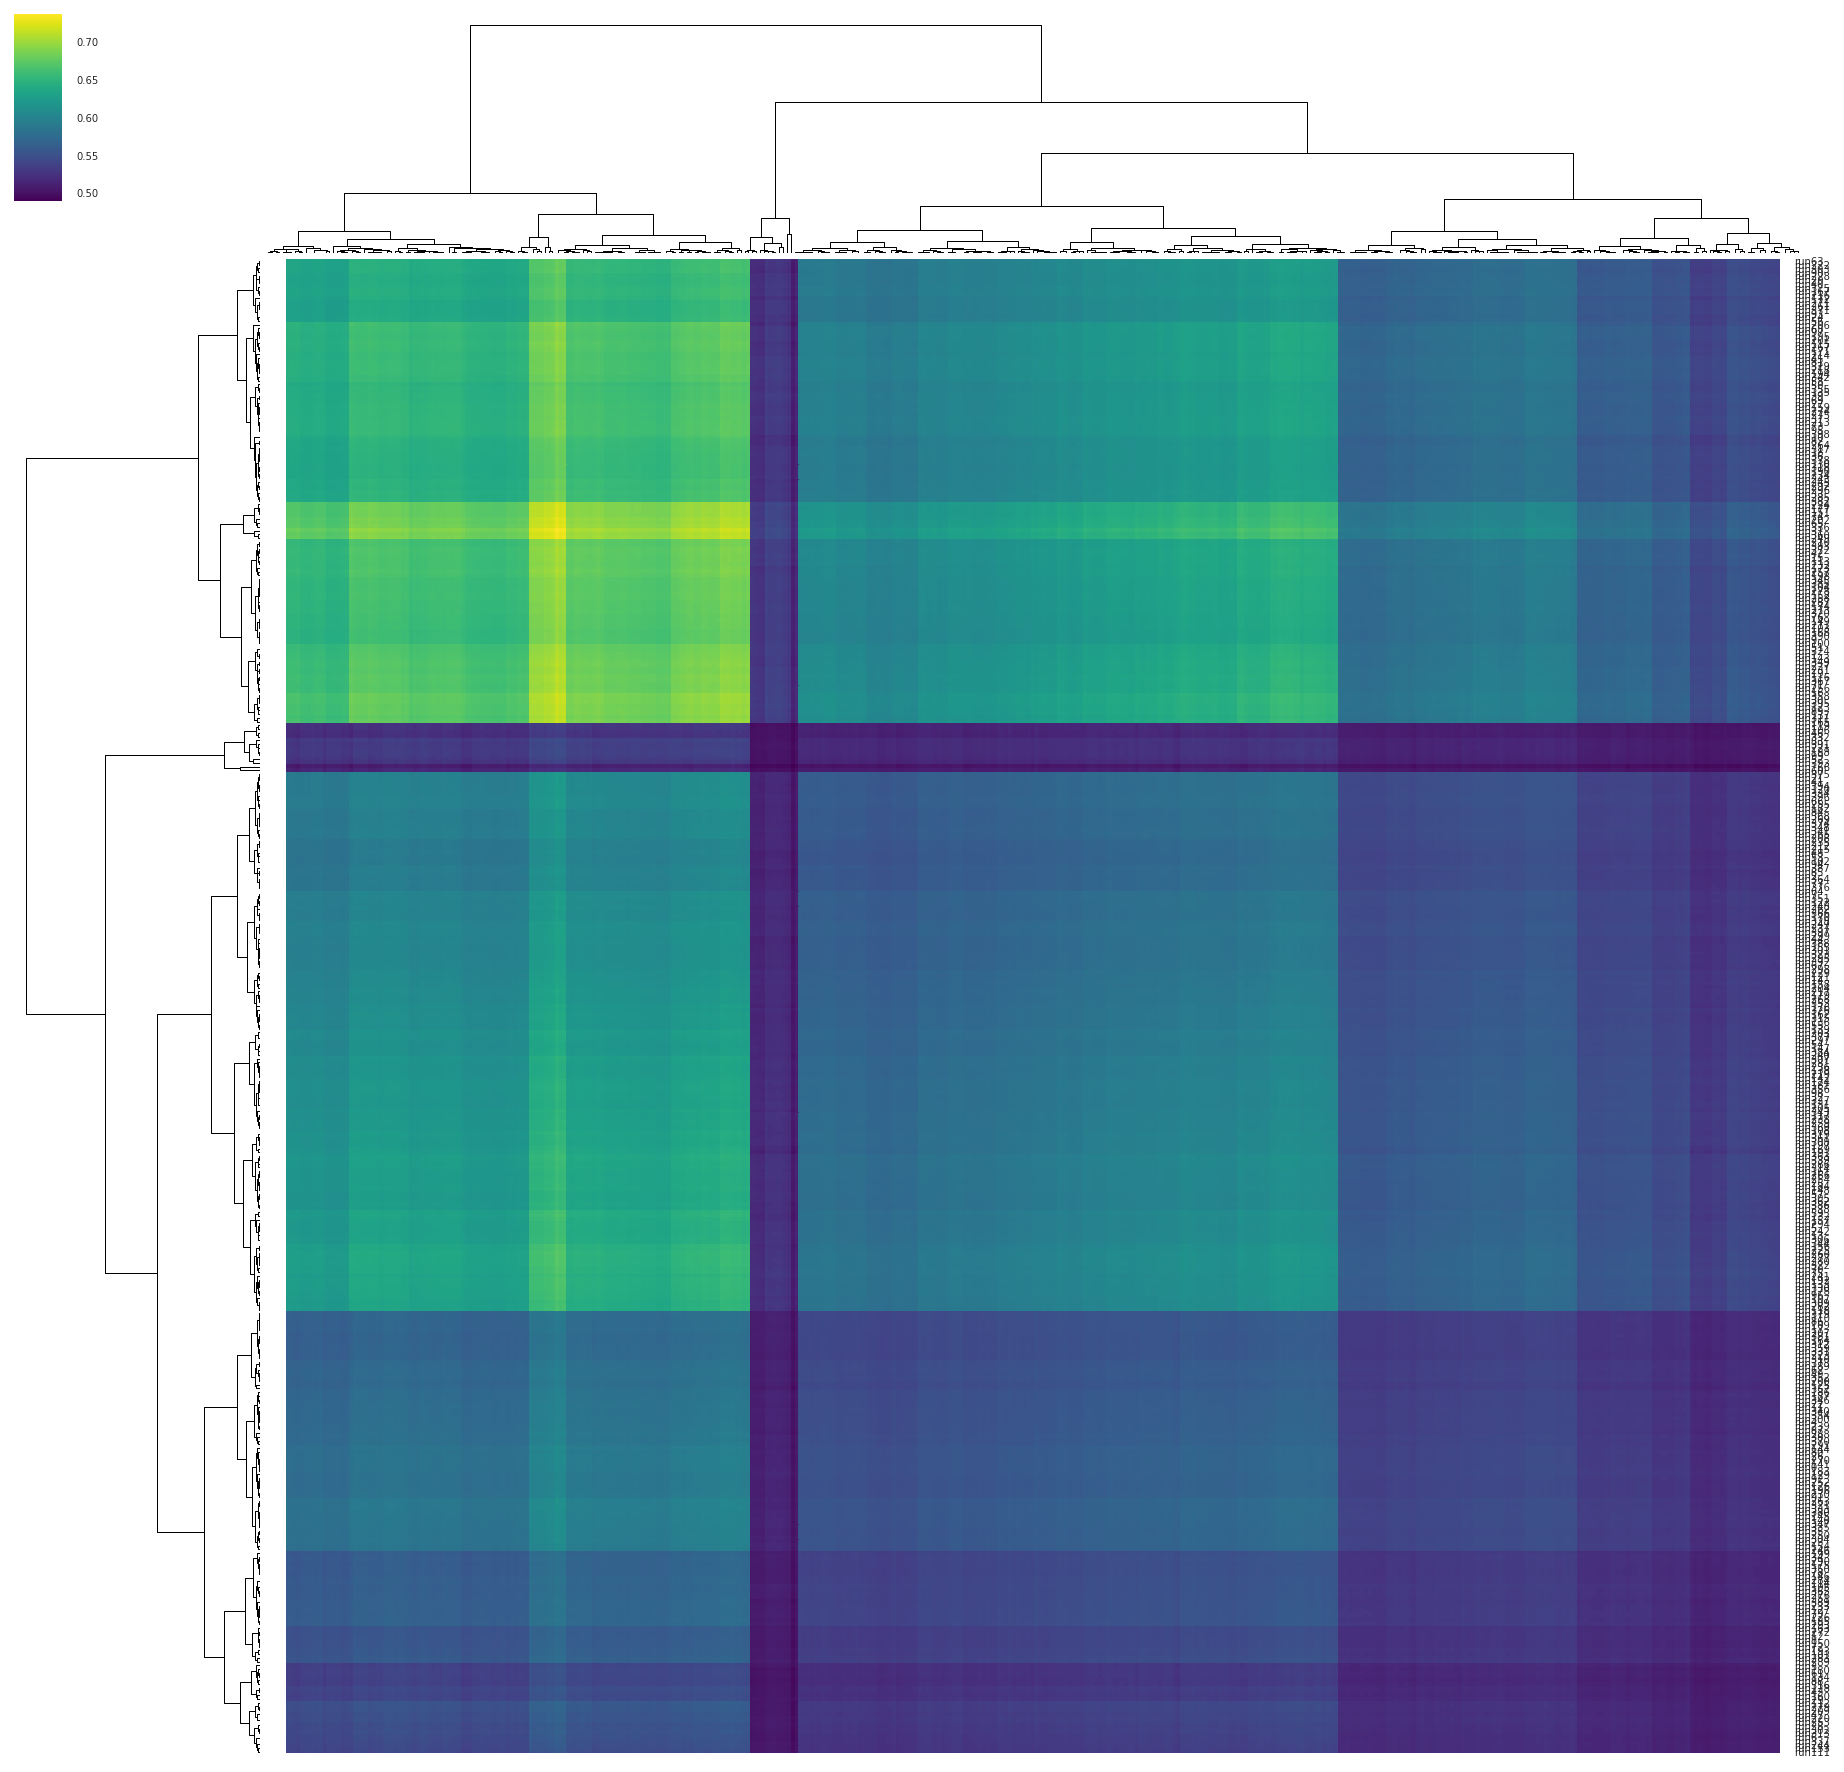

In [10]:
K = gk.CalculateConnectedGraphletKernel( igraphs.values() )

seaborn.set( font_scale=0.5 )
seaborn.clustermap( K, method='weighted', metric='braycurtis',
                    cmap='viridis', figsize=(16,16),
                    xticklabels=False, yticklabels=igraphs.keys(),
                    cbar=True, square=True )

ValueError: The condensed distance matrix must contain only finite values.

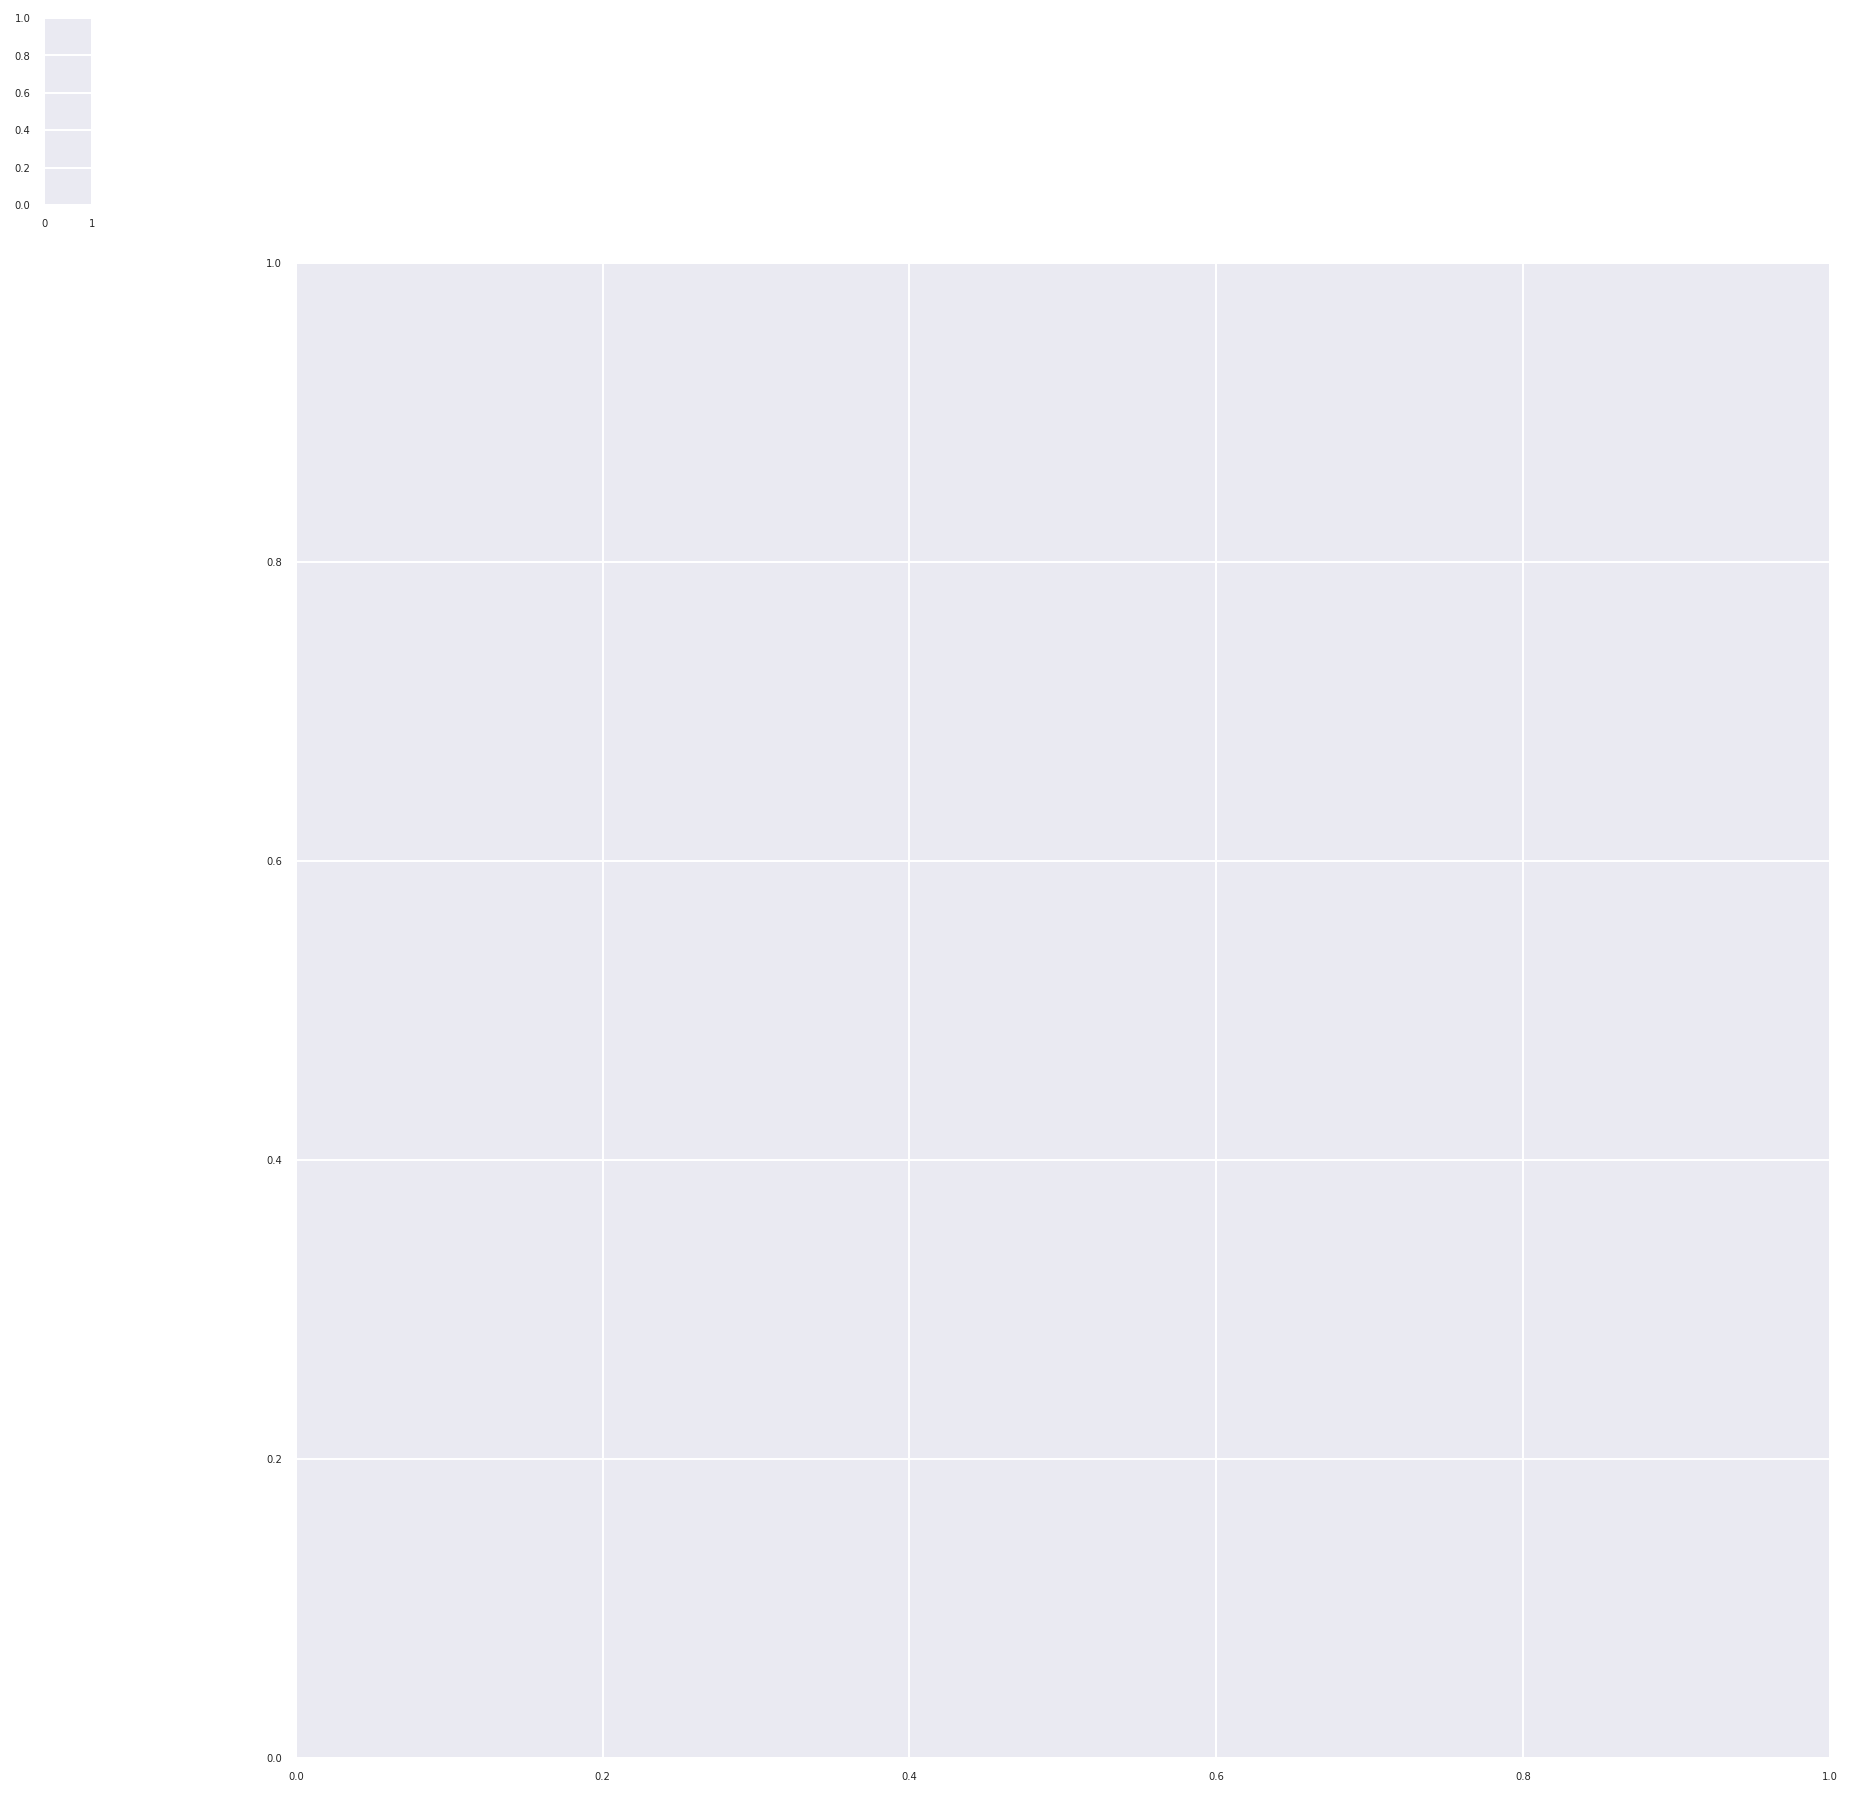

In [11]:
K = gk.CalculateWLKernel( igraphs.values() + [ i['igraph'] for i in studies ] )

seaborn.set( font_scale=0.5 )
seaborn.clustermap( K, method='weighted', metric='braycurtis',
                    cmap='viridis', figsize=(16,16),
                    xticklabels=False, yticklabels=igraphs.keys() + [ i['name'] for i in studies ],
                    cbar=True, square=True )

In [12]:
# load microbiome interactions

host_tree  = SuchTree( 'host_tree/mcgeetree/mcgee_trimmed.tree' )
guest_tree = SuchTree( 'dissertation_run_unique_2_pruned.tree' )
links      = pandas.read_csv( 'dissertation_run_host_abundance_table_filtered.tsv',
                              sep='\t', index_col=0 )

SLT = SuchLinkedTrees( host_tree, guest_tree, links )

In [13]:
#progbar = pyprind.ProgBar( len(SLT.TreeB.get_internal_nodes()), 
#                           monitor=True, title='Building graphs...' )

progbar = pyprind.ProgBar( 10000, monitor=True, title='Building graphs...' )

ajs = {}
igs = {}
for n,nodeid in enumerate(SLT.TreeB.get_internal_nodes()) :
    progbar.update()
    if n > 10000 : break
    SLT.subset_b( nodeid )
    if SLT.subset_b_size < 5 :
        continue
    if SLT.subset_n_links > 2500 :
        continue
    
    ajs[nodeid] = SLT.adjacency()
    igs[nodeid] = SLT_to_igraph( SLT )

Building graphs...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:03:14

Total time elapsed: 00:03:14

Total time elapsed: 00:03:14


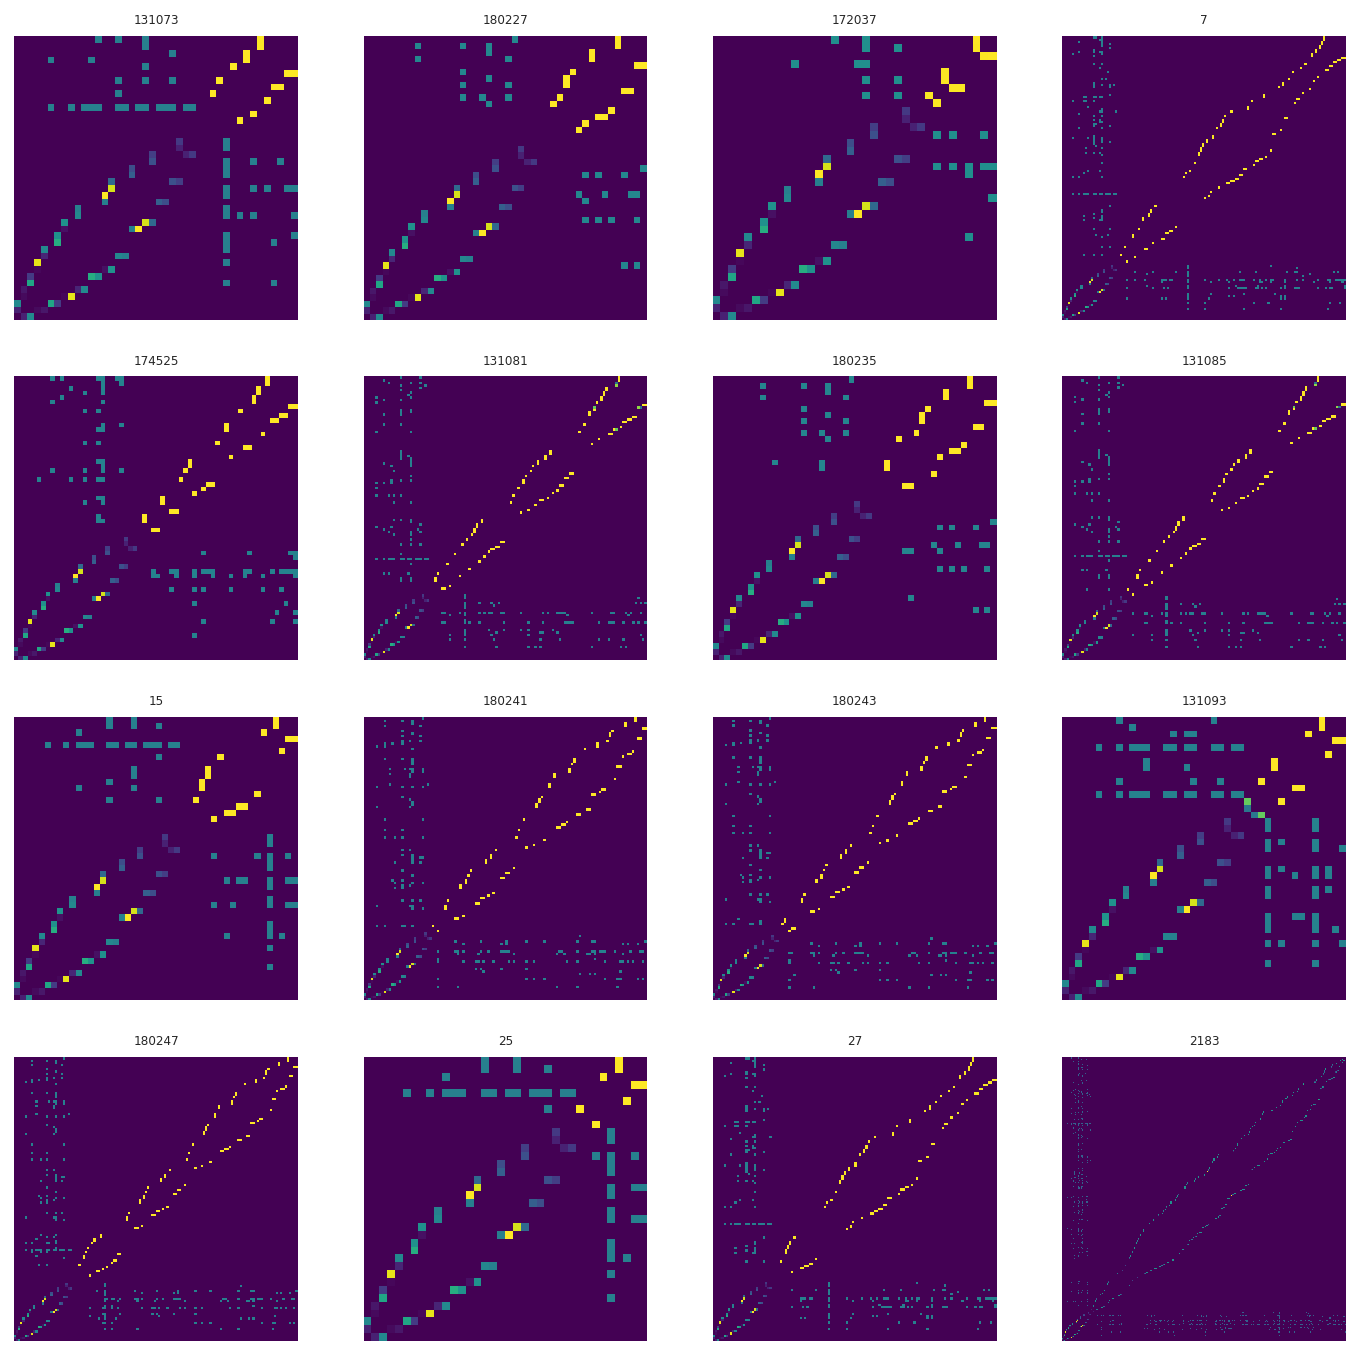

In [35]:
figure( figsize=(12,12) )

for i,n in enumerate( ajs.keys()[:16] ) :
    subplot(4,4,i+1)
    title( n )
    seaborn.heatmap( ajs[n], cmap='viridis', 
                     vmin=0, vmax=1,
                     xticklabels=False, yticklabels=False,
                     cbar=False, square=True ).invert_yaxis()

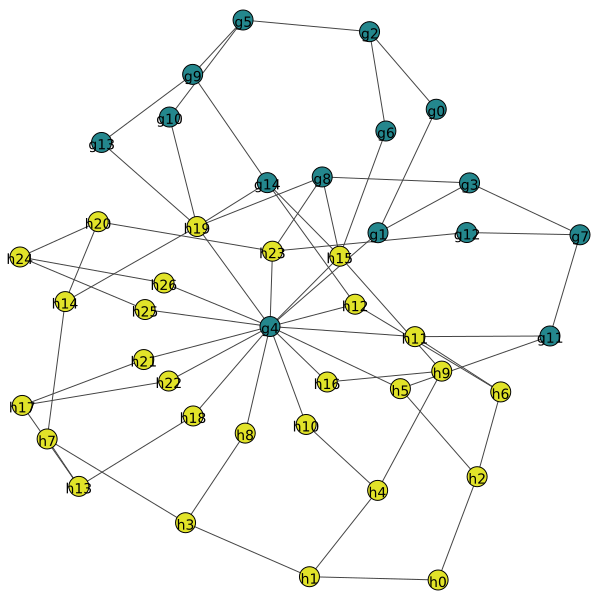

In [36]:
layout = igs.values()[0].layout_kamada_kawai()

igraph.plot( igs.values()[0], layout=layout )

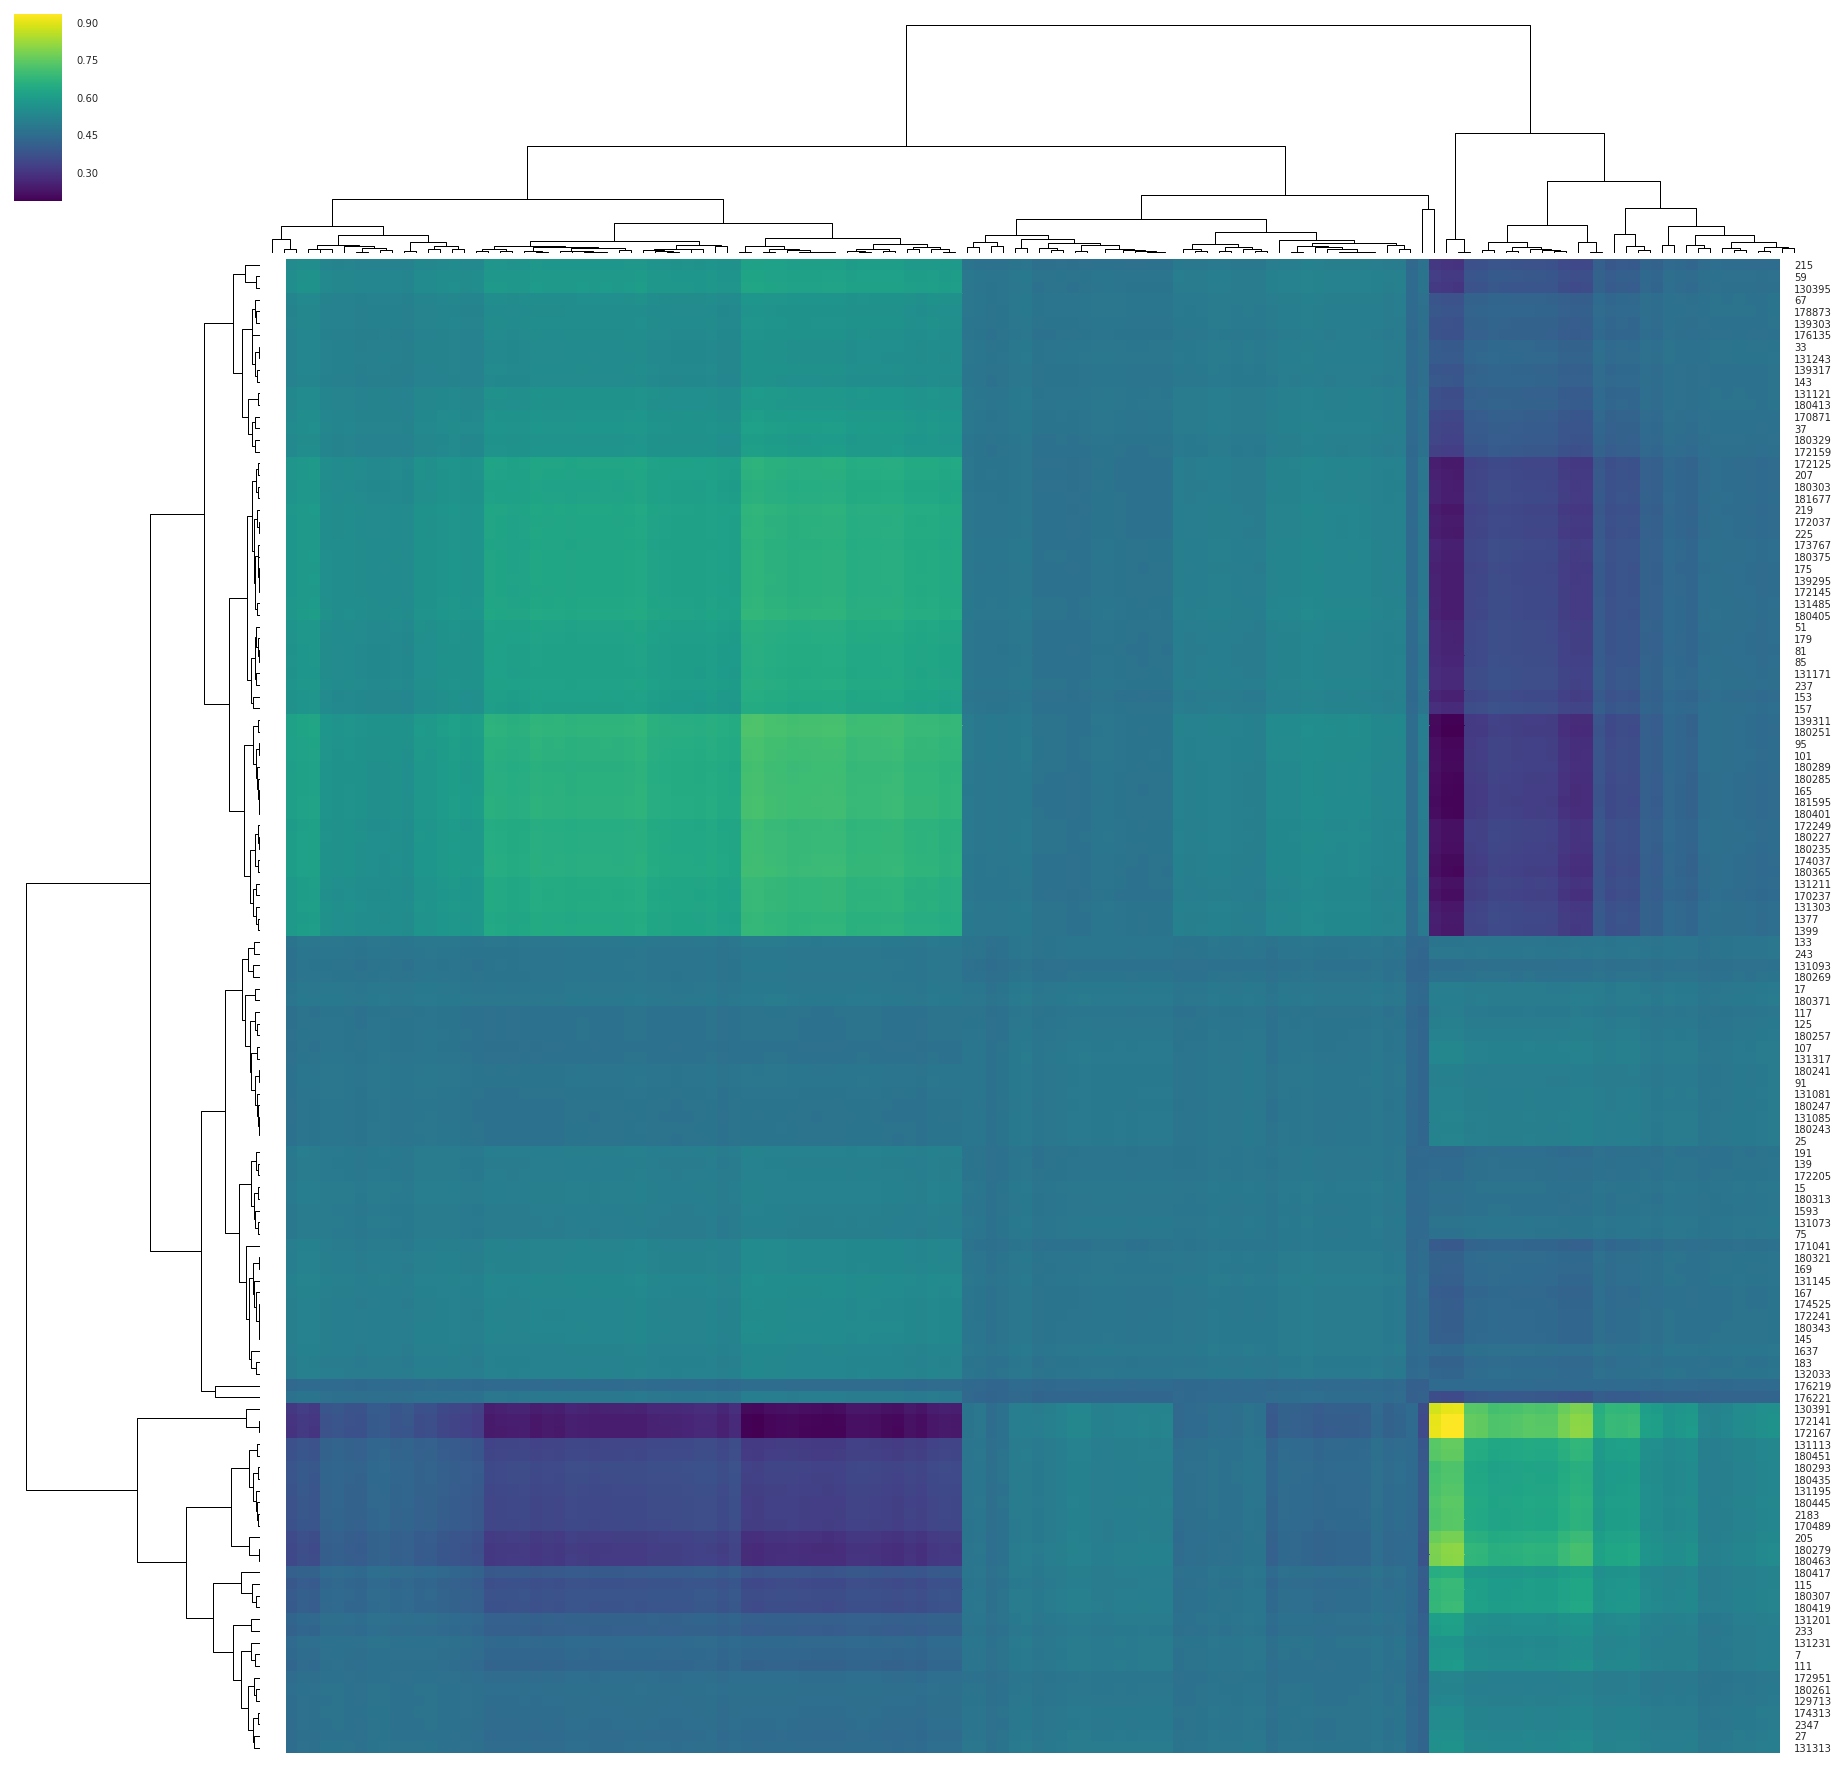

In [47]:
K = gk.CalculateConnectedGraphletKernel( igs.values()[:128] )

seaborn.set( font_scale=0.5 )
seaborn.clustermap( K, method='weighted', metric='braycurtis',
                    cmap='viridis', figsize=(16,16),
                    xticklabels=False, yticklabels=igs.keys()[:128],
                    cbar=True, square=True )

In [50]:
from itertools import permutations

In [56]:
distances = zeros( (len(ajs),len(ajs)) )
for (i,a),(j,b) in permutations( enumerate( ajs.keys() ), 2 ) :
    
    distances[i,j] = SLT.TreeB.distance( a, b )

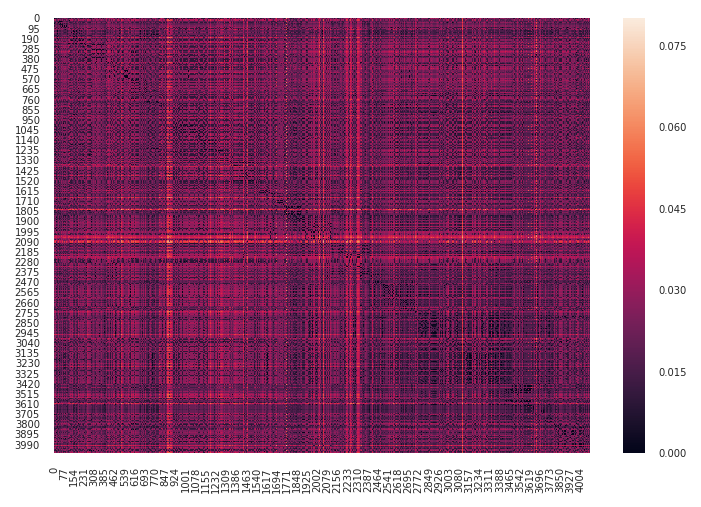

In [57]:
seaborn.heatmap(distances)

In [58]:
K = gk.CalculateConnectedGraphletKernel( igs.values() )

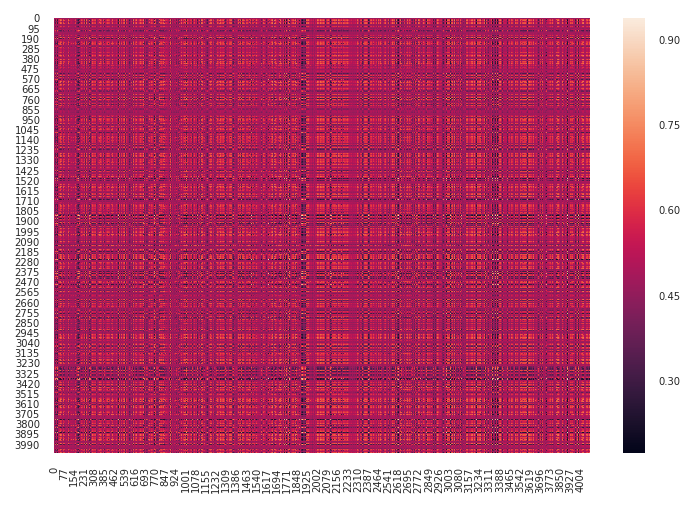

In [59]:
seaborn.heatmap(K)

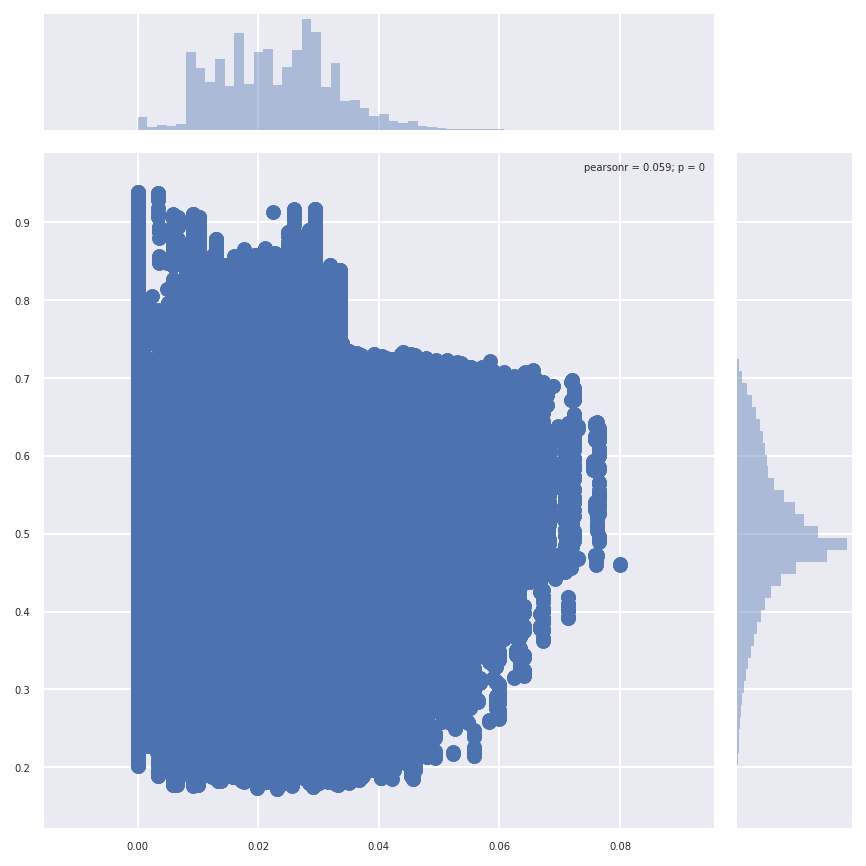

In [60]:
seaborn.jointplot( distances.flatten(), K.flatten() )